## Tesseract Features Test
This notebook aims at understanding whether Tesseract is an OCR Engine (optical character recognition) useful for our purposes.

In [65]:
# library import and constant definition
import matplotlib.pyplot as plt
import matplotlib.image as mpimg
import json
import re
import requests

import numpy as np
from skimage import data
from skimage.color import rgb2gray

import pytesseract
import os, os.path

import random
from pathlib import Path


cwd = os.getcwd()
print("Current working Directory:", cwd)

with open('./ALL.json', encoding="utf8") as json_file:
  magic_sets = json.load(json_file)
  magic_sets = magic_sets['data']

Current working Directory: D:\GitRepositories\CardSorterFantasia\MagicDatabaseDownloader


### EASY Test

In this section we test Tesseract features in the easiest cases. These test are useful because they cover most of the cards available.

At first we will create a new json containing only the sets that satisfy the following properties:
- Set released after 1 January 2015
- The set is only available in the online game [MTG Arena](!https://magic.wizards.com/it/mtgarena)
- The set's [code](!https://mtgjson.com/data-models/set/#code) is represented by less than 3 characters
<!-- (or it's [parent code](!https://mtgjson.com/data-models/set/#parentCode)) KISS for now -->

In [66]:
foo=0
for ms in magic_sets.copy():
    if magic_sets[ms]['releaseDate'] < '2015-01-01' or magic_sets[ms]['isOnlineOnly'] or len(magic_sets[ms]['code']) > 3:
        del magic_sets[ms]
    else:
        foo+=1
        print(ms+" --> "+magic_sets[ms]['code']+
            " > "+ (magic_sets[ms]['parentCode'] if 'parentCode' in magic_sets[ms] else "---")+
            "\t size: " + str(magic_sets[ms]['baseSetSize']), end=('\n' if foo % 3 == 0 else '\t|  ') )

2XM --> 2XM > ---	 size: 332	|  A25 --> A25 > ---	 size: 249	|  AER --> AER > ---	 size: 184
AKH --> AKH > ---	 size: 269	|  BBD --> BBD > ---	 size: 254	|  BFZ --> BFZ > ---	 size: 274
C15 --> C15 > ---	 size: 342	|  C16 --> C16 > ---	 size: 351	|  C17 --> C17 > ---	 size: 309
C18 --> C18 > ---	 size: 307	|  C19 --> C19 > ---	 size: 302	|  C20 --> C20 > ---	 size: 322
CC1 --> CC1 > ---	 size: 8	|  CM2 --> CM2 > ---	 size: 312	|  CMA --> CMA > ---	 size: 320
CMR --> CMR > ---	 size: 361	|  CN2 --> CN2 > ---	 size: 221	|  CP2 --> CP2 > FRF	 size: 6
CP3 --> CP3 > ORI	 size: 6	|  DDO --> DDO > ---	 size: 67	|  DDP --> DDP > ---	 size: 80
DDQ --> DDQ > ---	 size: 80	|  DDR --> DDR > ---	 size: 76	|  DDS --> DDS > ---	 size: 65
DDT --> DDT > ---	 size: 63	|  DDU --> DDU > ---	 size: 76	|  DOM --> DOM > ---	 size: 269
DTK --> DTK > ---	 size: 264	|  E01 --> E01 > ---	 size: 106	|  E02 --> E02 > ---	 size: 48
ELD --> ELD > ---	 size: 269	|  EMA --> EMA > ---	 size: 249	|  EMN --> EMN > ---	 s

In [160]:
magic_sets.keys()

dict_keys(['2XM', 'A25', 'AER', 'AKH', 'BBD', 'BFZ', 'C15', 'C16', 'C17', 'C18', 'C19', 'C20', 'CC1', 'CM2', 'CMA', 'CMR', 'CN2', 'CP2', 'CP3', 'DDO', 'DDP', 'DDQ', 'DDR', 'DDS', 'DDT', 'DDU', 'DOM', 'DTK', 'E01', 'E02', 'ELD', 'EMA', 'EMN', 'EXP', 'F15', 'F16', 'F17', 'F18', 'FRF', 'G17', 'G18', 'GK1', 'GK2', 'GN2', 'GNT', 'GRN', 'GS1', 'H17', 'HOU', 'HTR', 'IKO', 'IMA', 'J15', 'J16', 'J17', 'J18', 'J19', 'J20', 'J21', 'JMP', 'KHC', 'KHM', 'KLD', 'L15', 'L16', 'L17', 'M19', 'M20', 'M21', 'MB1', 'MED', 'MH1', 'MM2', 'MM3', 'MP2', 'MPS', 'OGW', 'ORI', 'PCA', 'PTG', 'RIX', 'RNA', 'SLD', 'SLU', 'SOI', 'SS1', 'SS2', 'SS3', 'STA', 'STX', 'THB', 'TSR', 'UMA', 'UND', 'UST', 'V15', 'V16', 'V17', 'W16', 'W17', 'WAR', 'XLN', 'ZNC', 'ZNE', 'ZNR'])

In [67]:
with open('./JSONs/EASY.json', 'w', encoding="utf8") as json_file:
  json.dump(magic_sets, json_file)

In [178]:
# Auxiliary functions
def black_over_white(img):
    # This function transforms an image into a greyscale and then
    # exchange the brightness. This is useful as tesseract works at
    # it's best on black text over white background while magic
    # cards are light text on dark background.
    grayscale = 255*(1-rgb2gray(img) )
    grayscale = grayscale.astype(np.uint8)
    return grayscale


def display_image(ax, img, grayscale, text):
    # This function prints a brief recap
    ax[0].imshow(img)
    ax[0].set_title("Original")
    ax[1].imshow(grayscale, cmap=plt.cm.gray)
    ax[1].set_title("Black over White")
    ax[2].imshow(255-0*img)
    ax[2].text(350, 450, text, ha='center', va='center', fontsize=9)
    
    
image_id_wildcard = '${card.identifiers.scryfallId}'
image_url = 'https://api.scryfall.com/cards/${card.identifiers.scryfallId}?format=image'
def get_card_img(card):
    # Funzione principale incaricata di scaricare le carte
    filename = "cards_db/"+card['setCode'] + "/"+ card['rarity'] + "/" + card['number'] + ".jpg"
    if not os.path.isfile(filename):
        Path("cards_db/"+card['setCode'] + "/"+ card['rarity'] + "/").mkdir(parents=True, exist_ok=True)

        scryfallId = card['identifiers']['scryfallId']

        url_img = image_url.replace(image_id_wildcard, scryfallId)
        r = requests.get(url_img, allow_redirects=True)
        open(filename, 'wb').write(r.content)
    
    return  mpimg.imread(filename).astype(np.uint8)


def get_card_info(text):
    card_ext = {
        'rarity': "",
        'setCode': "",
        'number': ""
    }
    
    m = re.search('[0-9A-Z]{3}\/[0-9]{3}\s[0-9A-Za-z]', text)
    if m:
        if m.group(0)[0] == '0':
            if m.group(0)[1] == '0':
                card_ext['number'] = m.group(0)[2]
            else:
                card_ext['number'] = m.group(0)[1:3]
        else:
            card_ext['number'] = m.group(0)[:3]
            
        if m.group(0)[-1:] == 'C':
            card_ext['rarity'] = 'common'
        elif m.group(0)[-1:] == 'U':
            card_ext['rarity'] = 'uncommon'
        elif m.group(0)[-1:] == 'M':
            card_ext['rarity'] = 'mythic'
        elif m.group(0)[-1:] == 'R':
            card_ext['rarity'] = 'rare'
        elif m.group(0)[-1:] == 'P': # we assume all promo cards to be classified as rareSirGGtheWanderer
            card_ext['rarity'] = 'rare'
        elif m.group(0)[-1:] == 'L':
            card_ext['rarity'] = 'common' #and all lands as common
    
    # Search on known codes
    for cd in magic_sets.keys():
        m = re.search( cd+'[^a-zA-Z0-9]', text )
        if m:
            card_ext['setCode'] = m.group(0)[:3]
            break
    else:
        print("SET MATCH NOT FOUND")
        print(text)

    return card_ext


### Test on known images

SET MATCH NOT FOUND
SET MATCH NOT FOUND


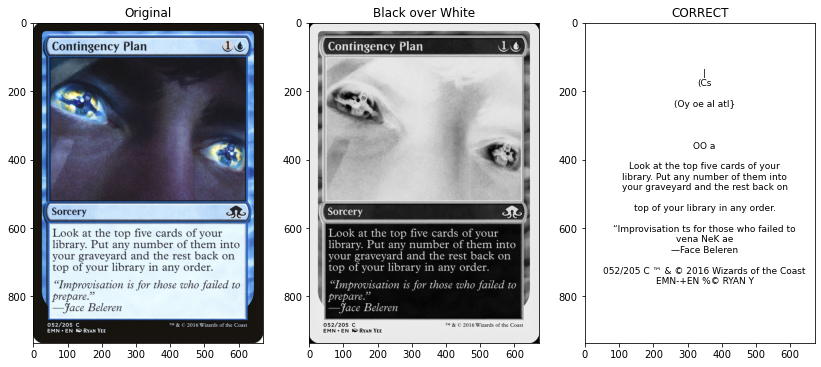

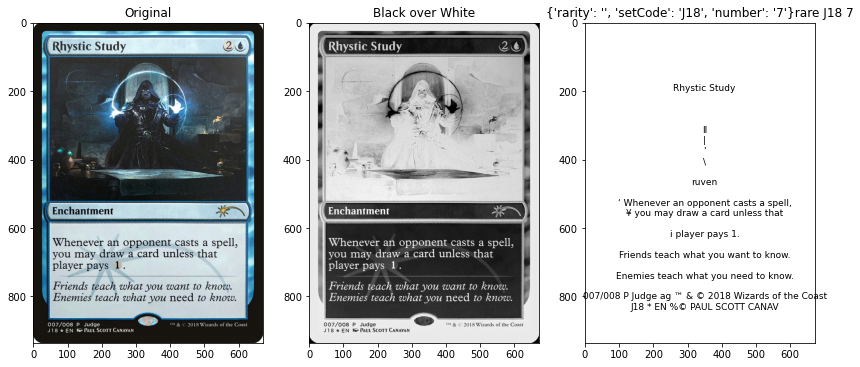

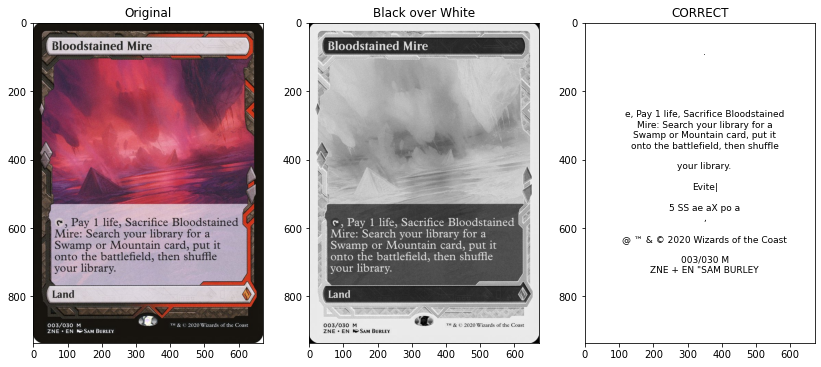

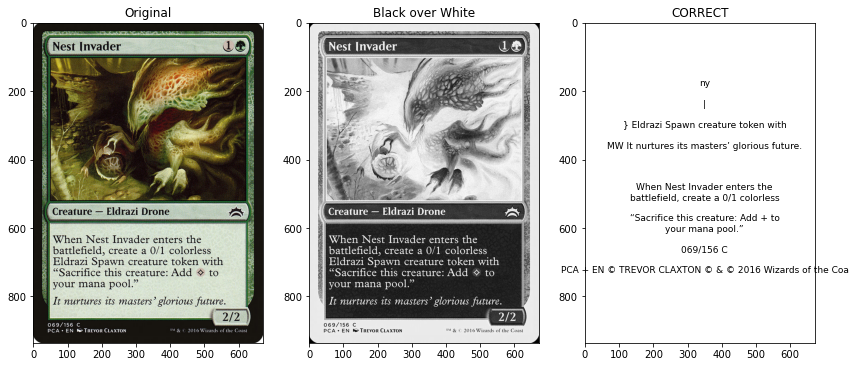

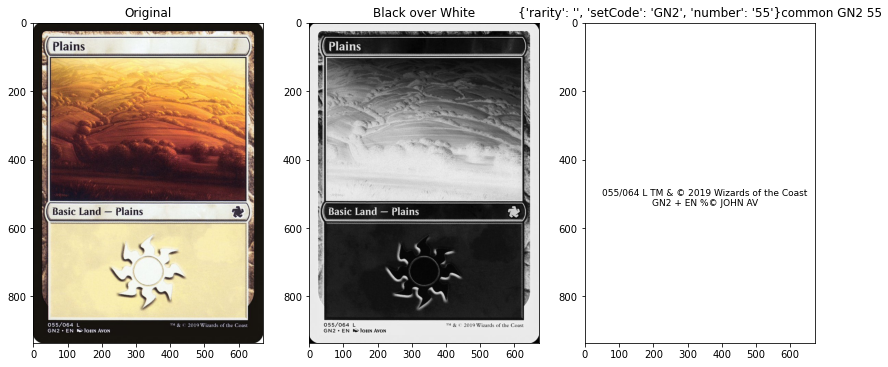

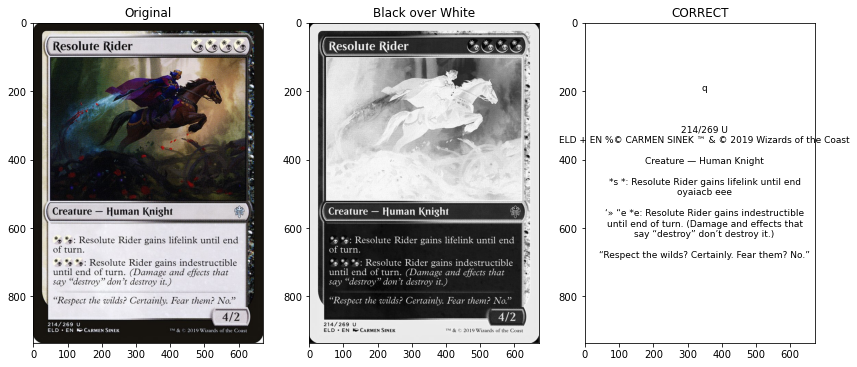

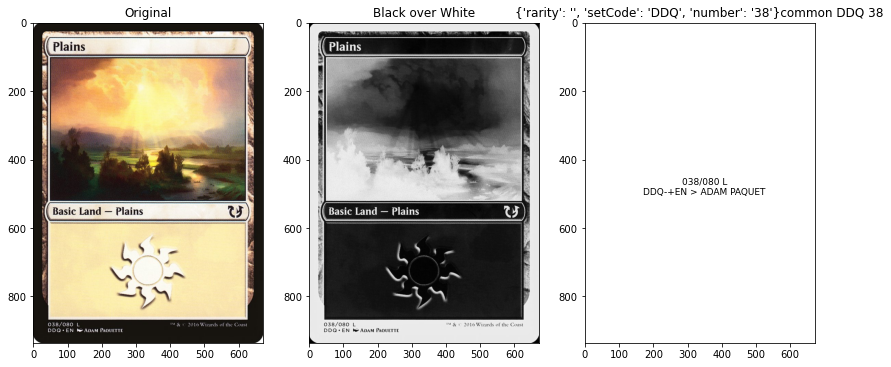

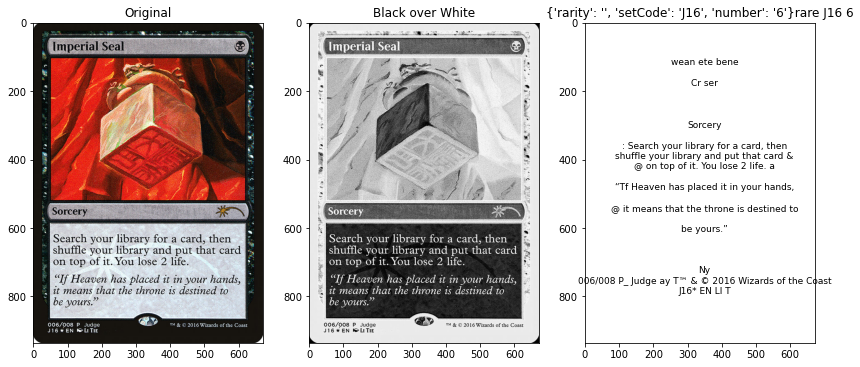

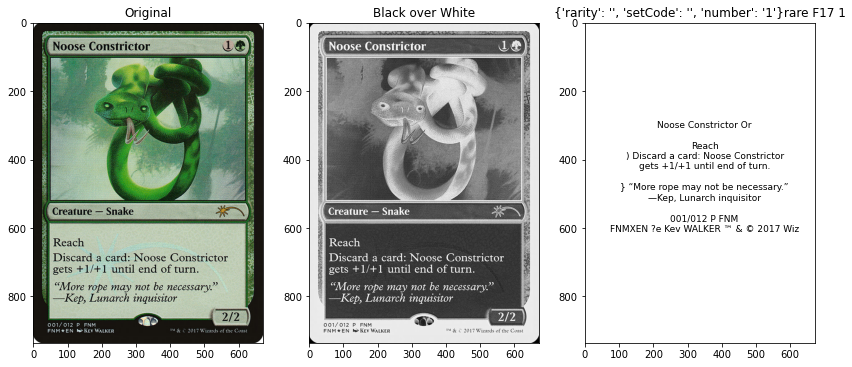

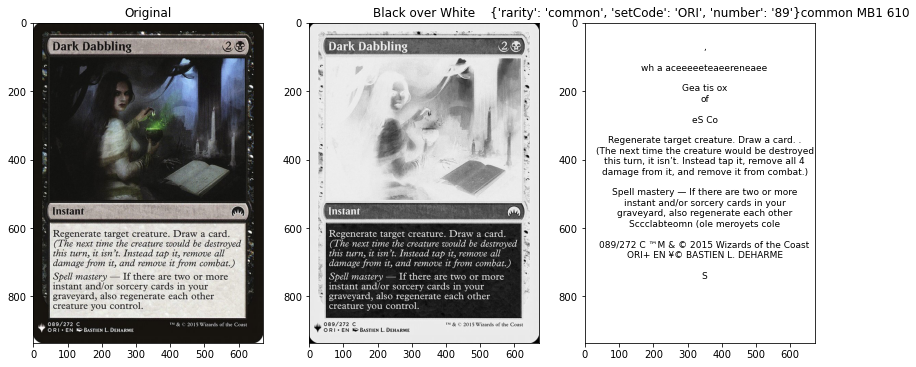

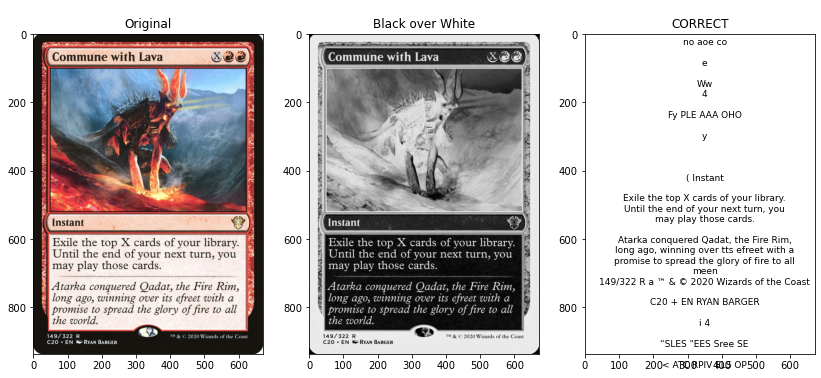

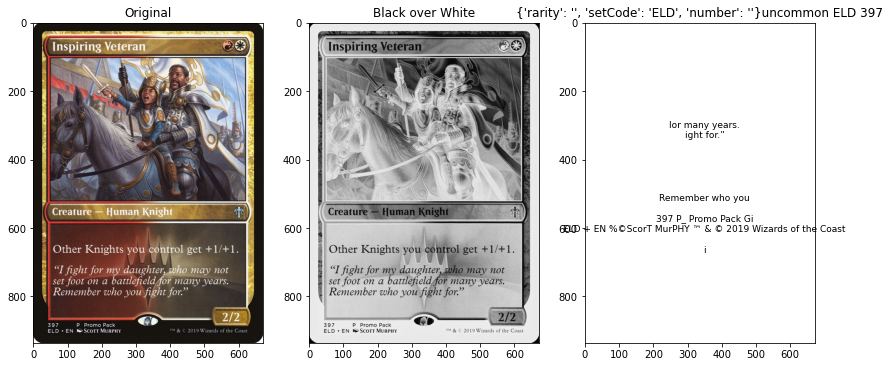

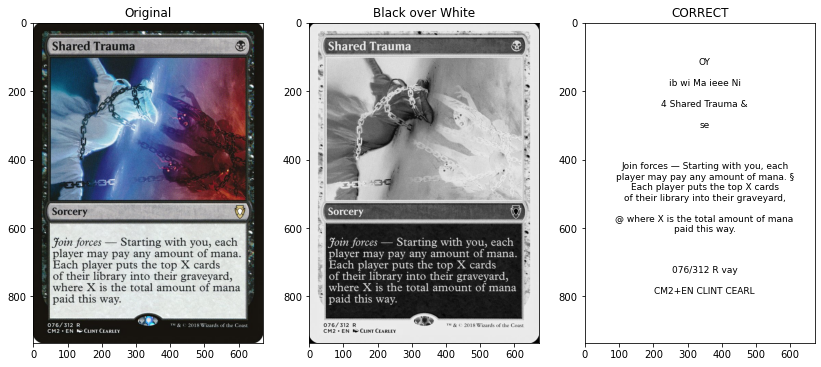

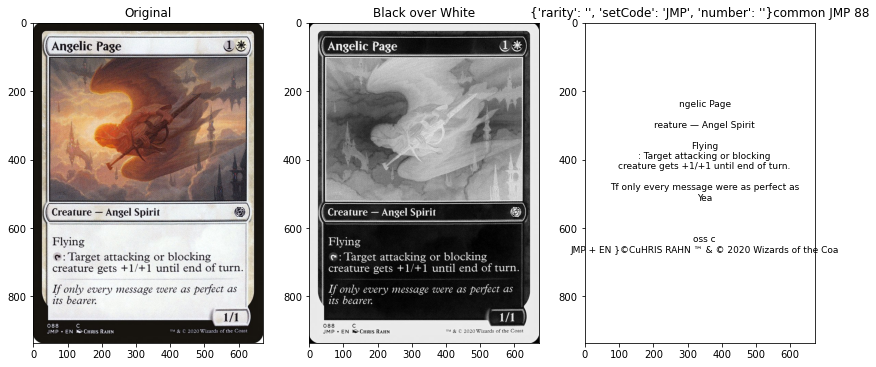

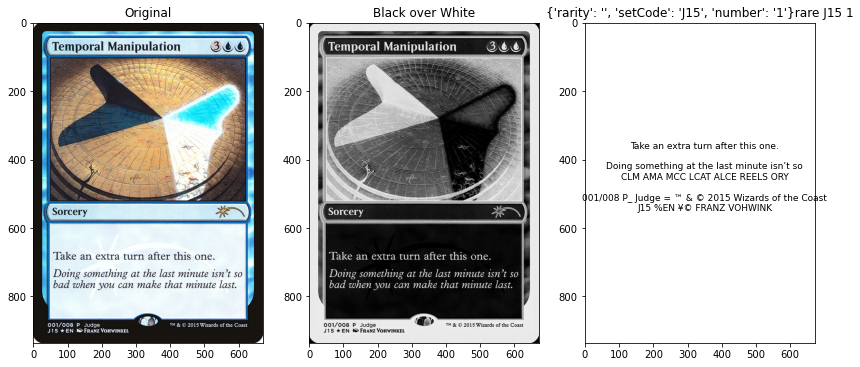

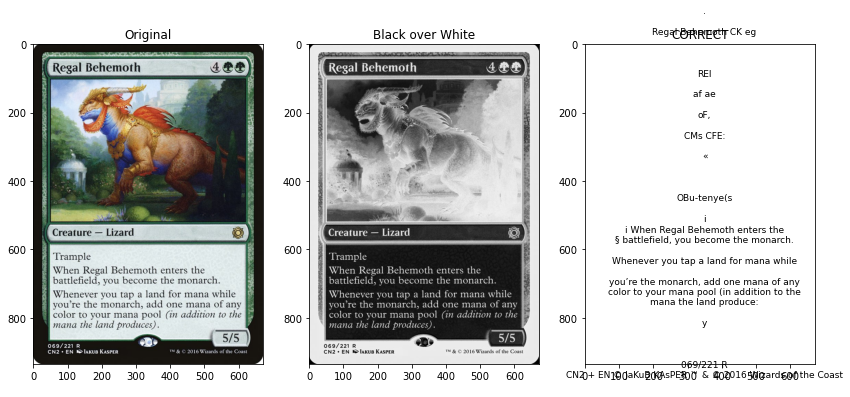

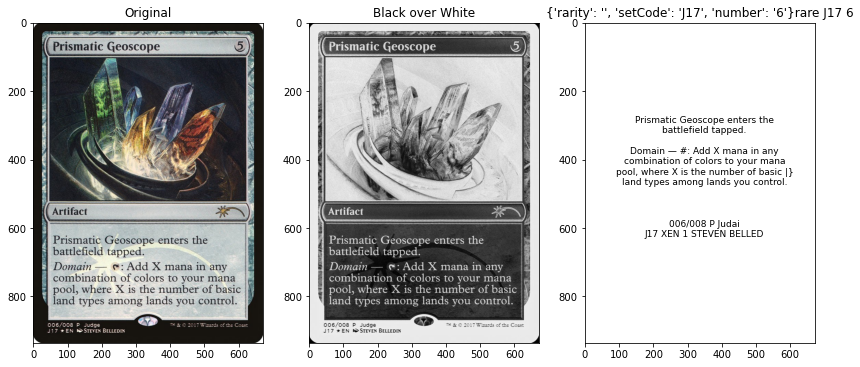

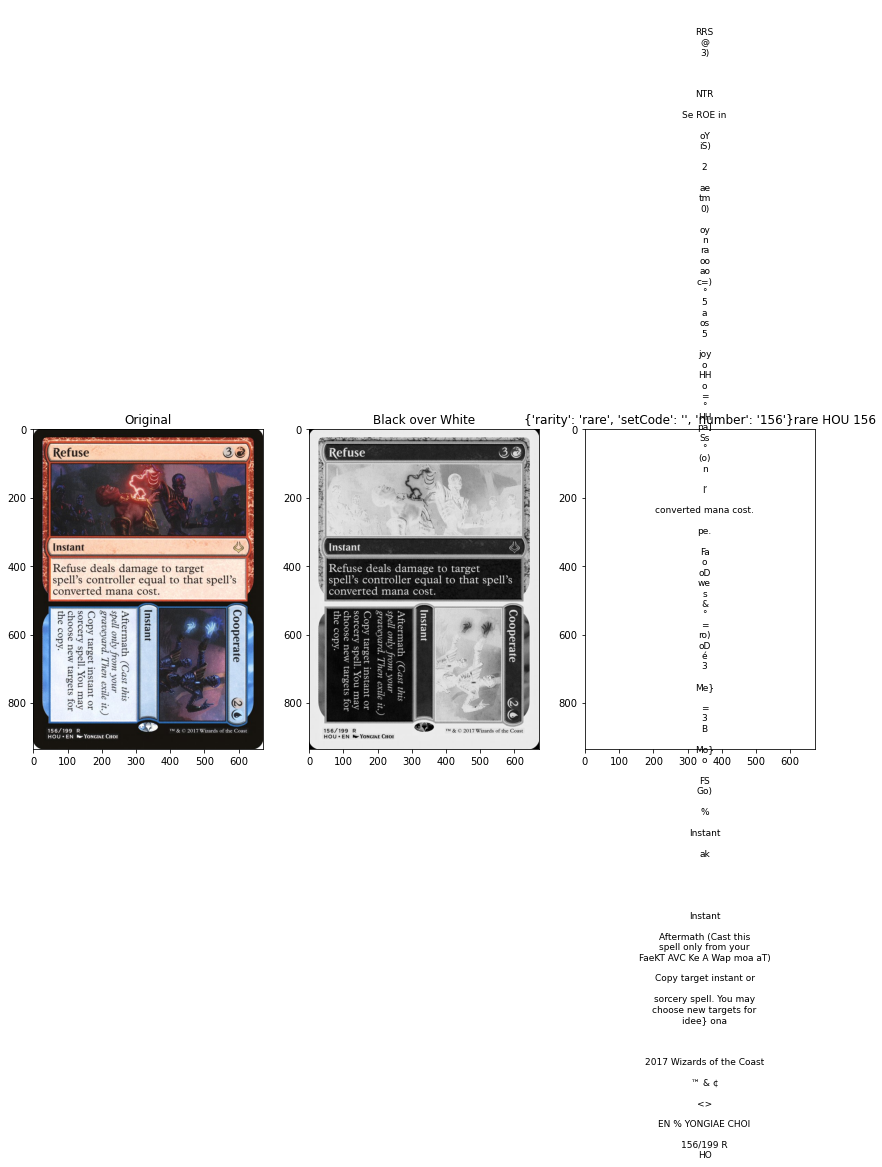

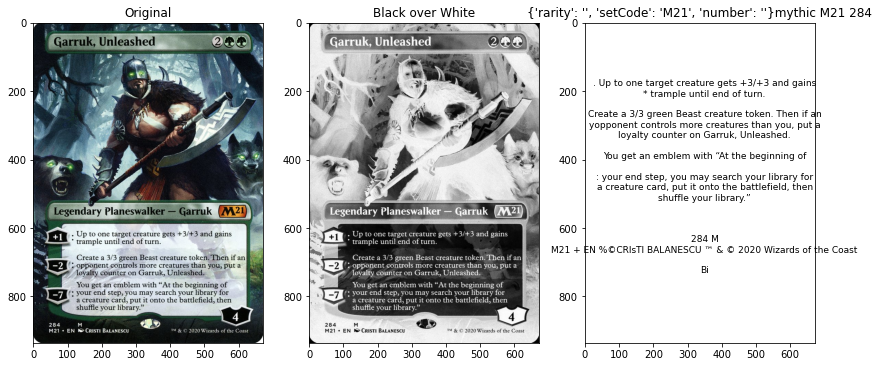

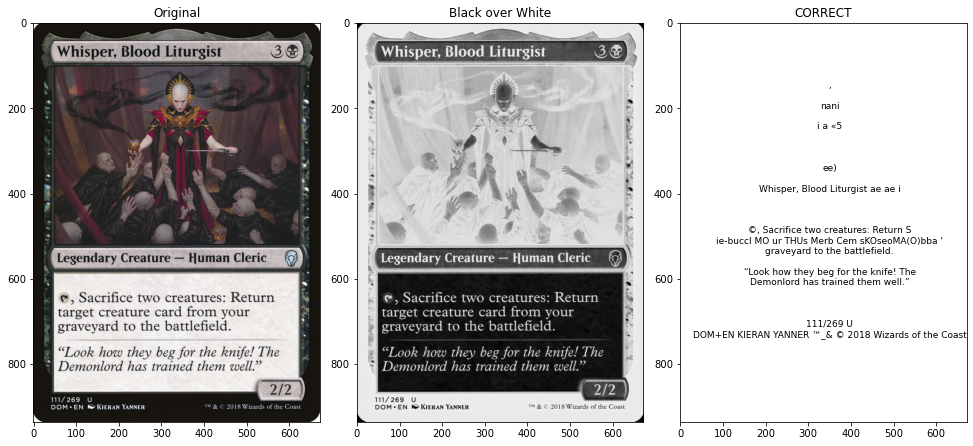

In [175]:
TEST_CASES = 20

#fig, ax = plt.subplots(10, 3, figsize=(14, 80), gridspec_kw={'width_ratios': [1, 1, 3]})

for i in range(TEST_CASES):
    fig, ax = plt.subplots(1, 3, figsize=(14, 8), gridspec_kw={'width_ratios': [1, 1, 1]})
    
    
    # Pick a random card from one of the EASY SETs
    rnd_ms = None
    rnd_card = None
    while not rnd_ms:
        rnd_ms = random.choice( list(magic_sets.keys()) )
    
    while not rnd_card:
        rnd_card = random.choice(magic_sets[rnd_ms]['cards'])

    img = get_card_img(rnd_card)
    grayscale = black_over_white(img)

    text = pytesseract.image_to_string(grayscale)
    text = str.rstrip(text)
    
    display_image(ax, img, grayscale, text[:-2])
    
    card_ext = get_card_info(text)
    
    if (card_ext['rarity'] == rnd_card['rarity']) and \
       (card_ext['setCode'] == rnd_card['setCode']) and \
       (card_ext['number'] == rnd_card['number']):
        title = "CORRECT"
    else:
        title = str(card_ext)+ rnd_card['rarity']+" "+rnd_card['setCode']+" "+rnd_card['number']
    ax[2].set_title(title)

fig.tight_layout()
plt.show()


### Other stuffs

In [ ]:
m = re.search('[0-9A-Z]{3}\/[0-9]{3}\s[0-9A-Za-z]', text)
print(m.group(0))

# U stands for uncommon
# RNA è l'espansione

# Volendo si potrebbe trovare il set tramite il numero totale di carte (supponendo che ogni espansione abbia un numero diverso di carte)

# Costrire vettore con tutte le sigle delle estensioni

m = re.search( 'C15[^a-zA-Z0-9-]', text )
print(m.group(0))




In [35]:
def add_gaussian_noise(img, mu, sigma):
    # This functions add a random gaussian noise to the image.
    # We used this function to test tesseracts performances under stress.
    
    noise = np.random.normal(mu, sigma, size=img.shape).astype(np.uint8)
    
    # output is clipped so that only correct values are returned.
    # This enhance values around 0 and 255 but overhall it's a
    # fairy effective methods for its semplicity.
    return (img + noise).clip(0, 255)


for ms in magic_sets:
    if magic_sets[ms]['releaseDate'] > '2015-01-01':
        if not magic_sets[ms]['isOnlineOnly']:
            if len(magic_sets[ms]['code']) > 3 and 'parentCode' in magic_sets[ms]:
                print()
                #print(ms+" --> "+magic_sets[ms]['code']+
                #          "\t--> "+magic_sets[ms]['parentCode']+
                #          " -- " + str(magic_sets[ms]['baseSetSize']) )
            elif len(magic_sets[ms]['code']) > 3: 
                print(ms+" --> "+magic_sets[ms]['code']+
                          "\t--> "+":("+
                          " -- " + str(magic_sets[ms]['baseSetSize']) )
                #print(ms+" --> "+magic_sets[ms]['code']+" -- " + str(magic_sets[ms]['baseSetSize']) )
                
# A := Art


# PLIST ha problemi perchè sono ristampe di carte vecchie sparse. L'unica differenza è che c'è un simbolo in basso a sx

HTR17 --> HTR17	--> :( -- 3  
HTR18 --> HTR18	--> :( -- 4  
PF19 --> PF19	--> :( -- 7  
PF20 --> PF20	--> :( -- 6  
PL21 --> PL21	--> :( -- 2  
PLGS --> PLGS	--> :( -- 2  
PLIST --> PLIST	--> :( -- 330  
PLNY --> PLNY	--> :( -- 1  
PNAT --> PNAT	--> :( -- 1  
PS15 --> PS15	--> :( -- 5  
PS16 --> PS16	--> :( -- 5  
PS17 --> PS17	--> :( -- 6  
PS18 --> PS18	--> :( -- 5  
PS19 --> PS19	--> :( -- 5  